In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.layers import RandomRotation, RandomCrop, RandomZoom, RandomTranslation
from tensorflow import cast, expand_dims, float32

from skimage.transform import resize

/tmp/ipykernel_31280/3043572594.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-08 15:46:07.526575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 15:46:07.526629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 15:46:07.556923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [3]:
# Link: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

train = pd.read_csv("../data/sign_mnist_train.csv")
test = pd.read_csv("../data/sign_mnist_test.csv")

In [4]:
images, labels = train.iloc[:, 1:], train["label"]

In [5]:
labels = to_categorical(labels, num_classes=25)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=42)

In [7]:
# Scales the pixel values from the original range of 0 to 255 to a normalized range between 0 and 1.
# Trains faster and improves overall performance.
X_train = X_train.values / 255.0
X_test = X_test.values / 255.0

In [8]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [9]:
new_size = (112, 112)

X_train = np.array([resize(img, new_size) for img in X_train])
X_test = np.array([resize(img, new_size) for img in X_test])

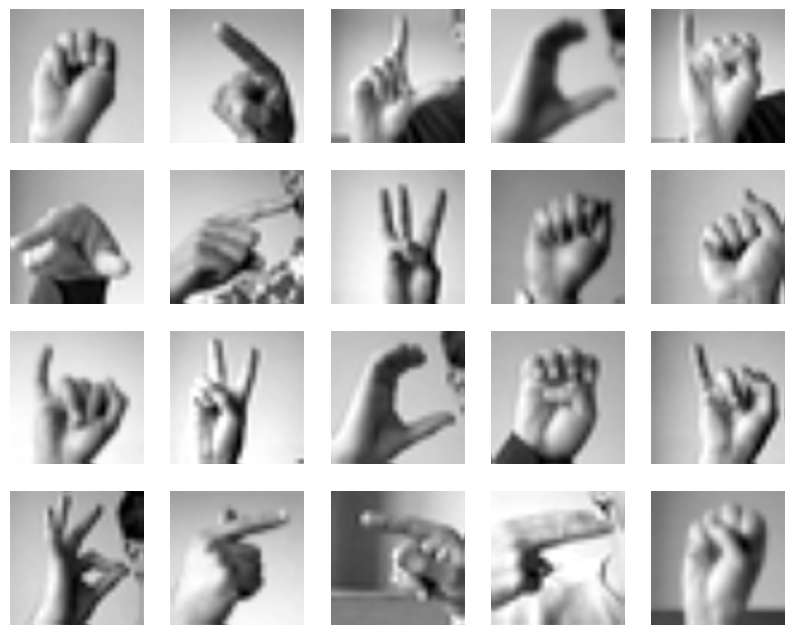

In [10]:
plt.figure(figsize=(10, 8))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.savefig("../images/variations.png", bbox_inches="tight")

In [11]:
X_train[0].shape

(112, 112, 1)

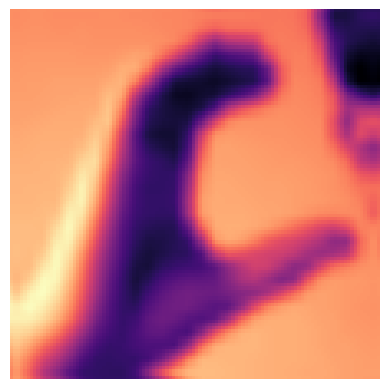

In [12]:
image = next(iter(X_train[3:]))
plt.imshow(image, cmap="magma")
plt.axis('off');

In [13]:
data_augmentation = Sequential(
    [RandomRotation(0.15), RandomCrop(height=100, width=100), RandomZoom(0.2, 0.2), RandomTranslation(width_factor=(0.2), height_factor=(0.2), fill_mode='nearest')]
)

2024-02-08 15:46:33.310667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:46:33.436786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:46:33.436831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:46:33.438347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:46:33.438410: I external/local_xla/xla/stream_executor

In [14]:
image = cast(expand_dims(image, 0), float32)

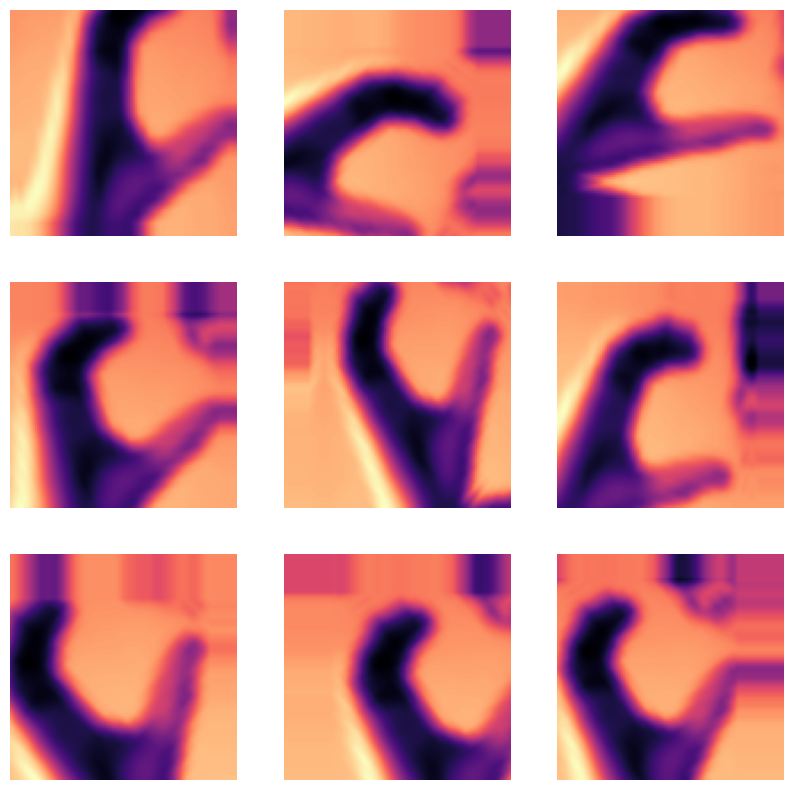

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0], cmap="magma")
    plt.axis("off")
plt.savefig('../images/augmentation.png', bbox_inches = 'tight')

In [16]:
model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(32, 3, activation="relu", padding="same", input_shape=(25, 25, 1)))
model.add(MaxPooling2D(2))


model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(2))


model.add(Flatten())
model.add(Dense(512, activation="relu"))


model.add(Dense(25, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(
    patience=3, monitor="val_loss", restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
)

2024-02-08 15:46:35.566605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1033174016 exceeds 10% of free system memory.
2024-02-08 15:46:35.916758: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1033174016 exceeds 10% of free system memory.


Epoch 1/20


2024-02-08 15:46:37.578354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-08 15:46:37.731415: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-08 15:46:38.025550: I external/local_xla/xla/service/service.cc:168] XLA service 0x8911cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-08 15:46:38.025582: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-02-08 15:46:38.035323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707435998.118123   31461 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


322/322 [==============================] - 10s 19ms/step - loss: 2.8553 - acc: 0.1406 - val_loss: 2.0598 - val_acc: 0.3543
Epoch 2/20
322/322 [==============================] - 5s 15ms/step - loss: 1.9343 - acc: 0.3957 - val_loss: 1.0285 - val_acc: 0.6741
Epoch 3/20
322/322 [==============================] - 5s 14ms/step - loss: 1.2161 - acc: 0.6032 - val_loss: 0.5553 - val_acc: 0.8266
Epoch 4/20
322/322 [==============================] - 5s 15ms/step - loss: 0.8800 - acc: 0.7129 - val_loss: 0.3878 - val_acc: 0.8725
Epoch 5/20
322/322 [==============================] - 5s 14ms/step - loss: 0.6688 - acc: 0.7760 - val_loss: 0.3498 - val_acc: 0.8848
Epoch 6/20
322/322 [==============================] - 5s 15ms/step - loss: 0.5434 - acc: 0.8173 - val_loss: 0.2765 - val_acc: 0.8967
Epoch 7/20
322/322 [==============================] - 5s 15ms/step - loss: 0.4695 - acc: 0.8441 - val_loss: 0.1886 - val_acc: 0.9387
Epoch 8/20
322/322 [==============================] - 5s 15ms/step - loss: 0.39

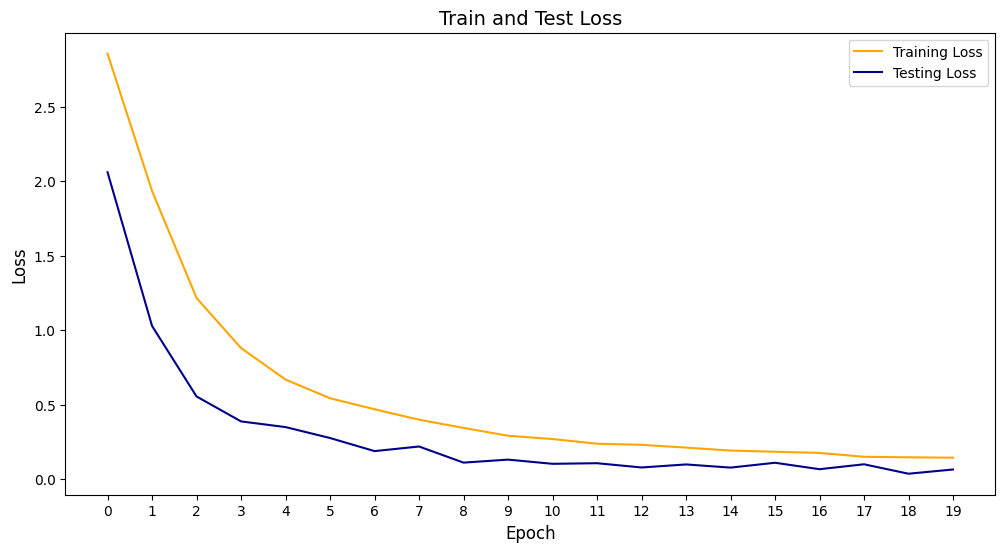

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], c="orange", label="Training Loss")
plt.plot(history.history["val_loss"], c="darkblue", label="Testing Loss")

x_ticks = [i for i in range(0, len(history.history["loss"]), 1)]
plt.xticks(x_ticks, x_ticks)

plt.title("Train and Test Loss", size=14)
plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.legend()
plt.savefig("../images/train_test_loss.png", bbox_inches="tight")

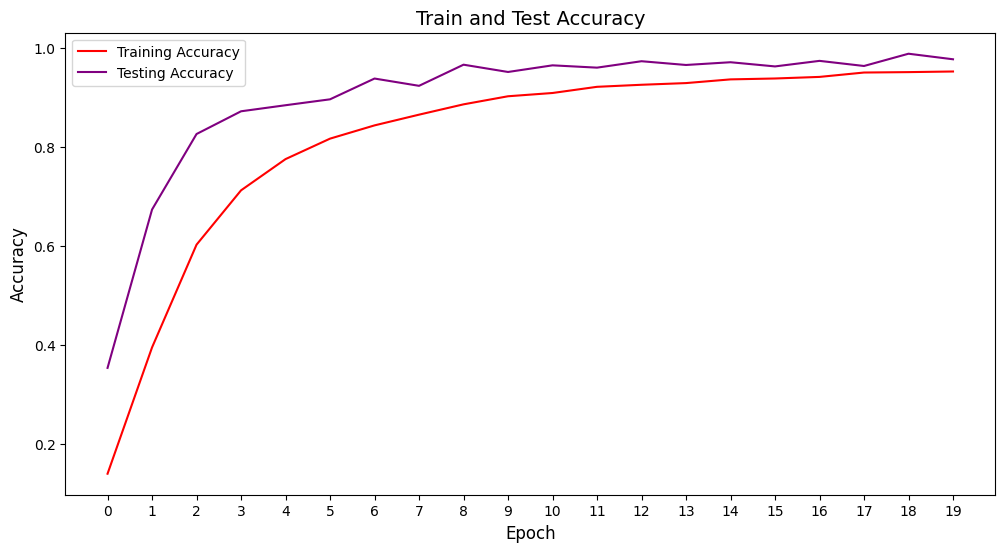

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(history.history["acc"], c="red", label="Training Accuracy")
plt.plot(history.history["val_acc"], c="purple", label="Testing Accuracy")

x_ticks = [i for i in range(0, len(history.history["loss"]), 1)]
plt.xticks(x_ticks, x_ticks)

plt.title("Train and Test Accuracy", size=14)
plt.xlabel("Epoch", size=12)
plt.ylabel("Accuracy", size=12)
plt.legend()
plt.savefig("../images/train_test_acc.png", bbox_inches="tight")

In [19]:
print(f"Test Accuracy: {model.evaluate(X_test, y_test)[1]:.4f}")
print(f"Train Accuracy: {model.evaluate(X_train, y_train)[1]:.4f}")

215/215 [==============================] - 1s 6ms/step - loss: 0.0653 - acc: 0.9776
Test Accuracy: 0.9776


2024-02-08 15:48:17.571034: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1033174016 exceeds 10% of free system memory.
2024-02-08 15:48:17.954922: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1033174016 exceeds 10% of free system memory.


644/644 [==============================] - 4s 6ms/step - loss: 0.0625 - acc: 0.9785
Train Accuracy: 0.9785


In [20]:
# Save model
model.save("../data/model.h5")

/home/landryhouston/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
